## Create a notebook to perform Runge-Kutta integration for multiple coupled variables

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Define our coupled derivatives to integrate

In [26]:
def dfdx(x, f):
    
    y = f[0]
    z = f[1]
    
    #return the derivatives
    dydx = np.zeros_like(f)
    dydx[0] = z
    dydx[1] = -1*y
    
    return dydx

## Define the cash carp core function for multivariables

In [32]:
def cash_karp_core_mv(x_i, y_i, nv, h, f):
    
    #declare k# arrays
    
    ni = 7
    nj = 6
    ci = np.zeros(ni)
    aij = np.zeros((ni, nj))
    bi = np.zeros(ni)
    bis = np.zeros(ni)
    
    ci[2] = 1./5.
    ci[3] = 3./10.
    ci[4] = 3./5.
    ci[5] = 1.
    ci[6] = 7./8.
    
    aij[2,1] = 1./5.
    aij[3,1] = 3./40.
    aij[4,1] = 3./10.
    aij[5,1] = -11./54.
    aij[6,1] = 1631./55296.
    
    aij[3,2] = 9./40.
    aij[4,2] = -9./10.
    aij[5,2] = 5./2.
    aij[6,2] = 175./512.
    
    aij[4,3] = 6./5.
    aij[5,3] = -70./27.
    aij[6,3] = 575./13824.
    
    aij[5,4] = 35./27.
    aij[6,4] = 44275./110592.
    
    aij[6,4] = 253./4096.
    
    bi[1] = 37./378.
    bi[2] = 0.
    bi[3] = 250./621.
    bi[4] = 125./594.
    bi[5] = 0.
    bi[6] = 512./1771.
    
    bis[1] = 2825./27648.
    bis[2] = 0.
    bis[3] = 18575./48384
    bis[4] = 13525./55296
    bis[5] = 277./14336.
    bis[6] = 1./4.
    
    #defining k array
    ki = np.zeros((ni,nv))
    
    #compute ki
    for i in range(1, ni):
        xn = x_i + ci[i]*h
        
        yn = y_i.copy()
        for j in range(1, i):
            yn += aij[i, j]*ki[j,:]
            
        ki[i,:] = h*f(xn, yn)
        
    ynpo = y_i.copy()
    ynpos = y_i.copy()
    
    for i in range(1, ni):
        ynpo += bi[i] * ki[i,:]
        ynpos += bis[i] * ki[i,:]
        
    #getting the error
    Delta = np.fabs(ynpo-ynpos)
    
    return ynpo, Delta

## Define an adaptive step size drive for the cash karp method

In [33]:
def cash_karp_mv_ad(dfdx, x_i, y_i, nv, h, tol):
    
    #define safety scale
    SAFETY    = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterations
    imax = 1000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv, 2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        y_ipo, Delta = cash_karp_core_mv(x_i, y_i, nv, h_step, dfdx)
        
        #if the error is too large, take a smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check the iteration
        if (i >= imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ", i)
            
        #iterate
        i += 1
        
    #next time we should try to make a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we actually took
    return y_ipo, h_new, h_step

## Define a wrapper for Cash Karp

In [34]:
def cash_karp_mv(dfdx, a, b, y_a, tol):
    
    #dfdx is the derivative wrt x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very teeny weeny!
    h = 1.0e-4 * (b-a)
    
    #set a maximum number of iterations
    imax = 1000
    
    #set an iteration variable
    i = 0
    
    #set the number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the intial conditions
    x = np.full(1, a)
    y = np.full((1, nv), y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        y_ipo, h_new, h_step = cash_karp_mv_ad(dfdx, xi, yi, nv, h, tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi + h_step > b):
            #take a smaller step
            h = b-xi
            
            #recalculate y_i + 1
            y_ipo, h_new, h_step = cash_karp_mv_ad(dfdx, xi, yi, nv, h, tol)
            
            #break
            flag = 0
            
        #update values
        xi += h_step
        yi = y_ipo.copy()
        
        #add the step to the arrays
        x = np.append(x, xi)
        y_ipo = np.zeros((len(x), nv))
        y_ipo[0:len(x) - 1, :] = y[:]
        y_ipo[-1, :] = yi[:]
        del y
        y = y_ipo
        
        #prevent too many iterations
        if(i >= imax):
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ", i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\ty = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, yi[0], h_step, b)
        print(s)
        
        #break if new xi is == b
        if(xi == b):
            flag = 0
            
    #return the answer
    return x,y

## Perform the integration

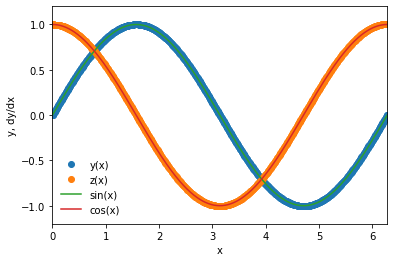

In [35]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = cash_karp_mv(dfdx, a, b, y_0, tolerance)
plt.plot(x, y[:,0], 'o', label='y(x)')
plt.plot(x, y[:,1], 'o', label='z(x)')
plt.plot(x, np.sin(x), label='sin(x)')
plt.plot(x, np.cos(x), label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.xlim([0, 2*np.pi])
plt.ylim([-1.2, 1.2])
plt.legend(frameon=False)

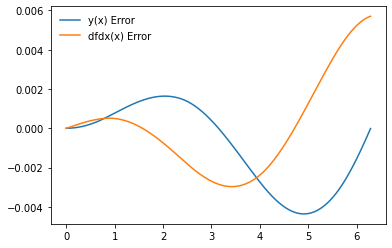

In [36]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:, 0] - sine)
dydx_error = (y[:, 1] - cosine)

plt.plot(x, y_error, label="y(x) Error")
plt.plot(x, dydx_error, label="dfdx(x) Error")
plt.legend(frameon=False)